In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from kneebow.rotor import Rotor
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np
import os
import re

## Funciones auxiliares

In [70]:
#We calculate or k-distance for determinate our eps value.
def calculate_kn_distance(X, neigh=2):
    neigh = NearestNeighbors(n_neighbors=neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    return distances[:,1:].reshape(-1)

#We get the eps exact value using kneebow, this function allows
#us to find the elbow of a curve by rotating the curve and taking
#the minimum value.
def get_eps(X, neigh=2):
    eps_dist = np.sort(calculate_kn_distance(X, neigh=neigh))
    rotor = Rotor()
    curve_xy = np.concatenate([np.arange(eps_dist.shape[0]).reshape(-1, 1), eps_dist.reshape(-1, 1)],1)
    rotor.fit_rotate(curve_xy)
    rotor.plot_elbow()
    e_idx = rotor.get_elbow_index()
    return curve_xy[e_idx]

## carga de datos 

In [71]:
edificios=pd.read_csv("../data/interim/estadisticas_edificios.csv")

In [72]:
edificios.head()

,type_building,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
0,RefBldgFullServiceRestaurantNew2004,36.968830,13.139998,71.651343,14.590618,33.836563,38.877634,43.668457,3.331869,1.490142,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
1,RefBldgFullServiceRestaurantNew2004,37.357872,13.459672,73.124359,14.610946,34.289907,39.231781,44.710691,3.327967,1.488397,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
2,RefBldgFullServiceRestaurantNew2004,37.896555,13.945362,72.745300,14.594486,34.285619,39.321435,45.983973,3.327124,1.488020,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
3,RefBldgFullServiceRestaurantNew2004,35.892184,12.083141,71.557828,14.600000,33.768150,38.689354,42.586655,3.303988,1.477673,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
4,RefBldgFullServiceRestaurantNew2004,35.976038,12.127984,70.203381,14.593106,33.934022,38.713755,42.615663,3.323298,1.486309,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147


In [73]:
edificios.isna().sum()

type_building                                               0
Electricity:Facility [kW](Hourly)_mean                      0
Electricity:Facility [kW](Hourly)_std_dev                   0
Electricity:Facility [kW](Hourly)_max_value                 0
Electricity:Facility [kW](Hourly)_min_value                 0
Electricity:Facility [kW](Hourly)_25_percentile             0
Electricity:Facility [kW](Hourly)_50_percentile             0
Electricity:Facility [kW](Hourly)_75_percentile             0
Fans:Electricity [kW](Hourly)_mean                          0
Fans:Electricity [kW](Hourly)_std_dev                       0
Fans:Electricity [kW](Hourly)_max_value                     0
Fans:Electricity [kW](Hourly)_min_value                     0
Fans:Electricity [kW](Hourly)_25_percentile                 0
Fans:Electricity [kW](Hourly)_50_percentile                 0
Fans:Electricity [kW](Hourly)_75_percentile                 0
Cooling:Electricity [kW](Hourly)_mean                       0
Cooling:

In [74]:
edificios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 43 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   type_building                                             80 non-null     object 
 1   Electricity:Facility [kW](Hourly)_mean                    80 non-null     float64
 2   Electricity:Facility [kW](Hourly)_std_dev                 80 non-null     float64
 3   Electricity:Facility [kW](Hourly)_max_value               80 non-null     float64
 4   Electricity:Facility [kW](Hourly)_min_value               80 non-null     float64
 5   Electricity:Facility [kW](Hourly)_25_percentile           80 non-null     float64
 6   Electricity:Facility [kW](Hourly)_50_percentile           80 non-null     float64
 7   Electricity:Facility [kW](Hourly)_75_percentile           80 non-null     float64
 8   Fans:Electricity [kW](

In [75]:
edificios.describe()

,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,205.896959,94.554094,443.477615,70.457995,127.069353,180.856123,277.715774,17.075134,7.016523,45.769114,...,13.192541,21.508703,84.586268,53.206147,24.728418,93.059567,26.638005,33.139539,44.721192,77.250456
std,294.490158,128.967601,549.446174,114.916877,220.106359,274.716614,385.373052,24.649374,9.107792,69.280486,...,14.829699,24.725756,117.099512,73.554009,31.327799,119.627218,41.686298,47.366172,61.317985,109.151424
min,7.474270,4.002892,19.802128,1.925019,4.778024,6.033994,11.556660,1.217192,0.711591,2.184205,...,0.275003,0.550005,3.711679,2.781765,1.278151,4.950048,1.011600,1.011600,1.011600,4.400043
25%,32.447086,17.795171,89.810725,8.699267,17.785496,27.533792,48.293093,3.041448,1.416750,7.472911,...,3.105893,5.451126,20.528760,11.311712,4.654335,16.250509,4.198793,7.411378,11.303727,16.250509
50%,78.139872,40.073529,224.347158,25.164031,44.778556,62.731332,110.190792,5.733951,4.100985,11.780199,...,4.801828,11.914006,37.735226,25.334649,13.133033,49.700376,8.760066,15.207416,22.338642,38.770934
75%,218.748632,81.871898,416.974453,78.435727,118.747199,197.050593,283.287781,21.543638,6.633711,37.988283,...,18.128048,23.766720,67.296722,58.264945,27.107491,113.141618,23.552351,33.079399,44.437106,78.163553
max,1120.479725,478.877942,1886.608295,508.413289,952.791133,1066.621718,1383.350524,102.154344,37.823520,304.000110,...,46.093034,100.150657,448.566544,265.854193,116.539481,448.566544,149.522181,174.442545,199.362908,398.725817


In [76]:
nombres_edificios=edificios.loc[:,"type_building"].copy()
print(nombres_edificios.size)
# Seleccionamos las columnas numéricas para normalización
numeric_columns = edificios.select_dtypes("number").columns
data_estadisticas=edificios[numeric_columns].copy()
print(data_estadisticas.size)

80
3360


In [77]:
data_estadisticas

,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
0,36.968830,13.139998,71.651343,14.590618,33.836563,38.877634,43.668457,3.331869,1.490142,3.998243,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.914700,7.4902,16.615675,19.4245,26.914700
1,37.357872,13.459672,73.124359,14.610946,34.289907,39.231781,44.710691,3.327967,1.488397,3.993560,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.914700,7.4902,16.615675,19.4245,26.914700
2,37.896555,13.945362,72.745300,14.594486,34.285619,39.321435,45.983973,3.327124,1.488020,3.992549,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.914700,7.4902,16.615675,19.4245,26.914700
3,35.892184,12.083141,71.557828,14.600000,33.768150,38.689354,42.586655,3.303988,1.477673,3.964785,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.914700,7.4902,16.615675,19.4245,26.914700
4,35.976038,12.127984,70.203381,14.593106,33.934022,38.713755,42.615663,3.323298,1.486309,3.987958,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.914700,7.4902,16.615675,19.4245,26.914700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,30.175031,23.336842,98.663271,6.492824,15.415824,18.091970,55.190270,4.129616,3.796352,8.839786,...,5.481225,5.481225,38.368572,3.311257,3.418924,9.104397,1.0116,1.011600,1.0116,8.092797
76,30.107071,23.487586,102.316208,6.492824,15.415824,17.735019,55.181013,4.019378,3.838025,8.830331,...,5.481225,5.481225,38.368572,3.311257,3.418924,9.104397,1.0116,1.011600,1.0116,8.092797
77,30.231607,23.595248,101.277888,6.492824,15.415824,17.727105,55.183069,4.009713,3.845784,8.832431,...,5.481225,5.481225,38.368572,3.311257,3.418924,9.104397,1.0116,1.011600,1.0116,8.092797
78,30.816260,23.756969,98.607616,6.492824,15.415824,18.540754,57.461629,5.188115,4.809714,11.227966,...,5.481225,5.481225,38.368572,3.311257,3.418924,9.104397,1.0116,1.011600,1.0116,8.092797


In [78]:
nombres_edificios.head()

0    RefBldgFullServiceRestaurantNew2004
1    RefBldgFullServiceRestaurantNew2004
2    RefBldgFullServiceRestaurantNew2004
3    RefBldgFullServiceRestaurantNew2004
4    RefBldgFullServiceRestaurantNew2004
Name: type_building, dtype: object

In [79]:
data_estadisticas.head()

,Electricity:Facility [kW](Hourly)_mean,Electricity:Facility [kW](Hourly)_std_dev,Electricity:Facility [kW](Hourly)_max_value,Electricity:Facility [kW](Hourly)_min_value,Electricity:Facility [kW](Hourly)_25_percentile,Electricity:Facility [kW](Hourly)_50_percentile,Electricity:Facility [kW](Hourly)_75_percentile,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
0,36.968830,13.139998,71.651343,14.590618,33.836563,38.877634,43.668457,3.331869,1.490142,3.998243,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
1,37.357872,13.459672,73.124359,14.610946,34.289907,39.231781,44.710691,3.327967,1.488397,3.993560,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
2,37.896555,13.945362,72.745300,14.594486,34.285619,39.321435,45.983973,3.327124,1.488020,3.992549,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
3,35.892184,12.083141,71.557828,14.600000,33.768150,38.689354,42.586655,3.303988,1.477673,3.964785,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
4,35.976038,12.127984,70.203381,14.593106,33.934022,38.713755,42.615663,3.323298,1.486309,3.987958,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147


In [80]:
data_estadisticas.columns

Index(['Electricity:Facility [kW](Hourly)_mean',
       'Electricity:Facility [kW](Hourly)_std_dev',
       'Electricity:Facility [kW](Hourly)_max_value',
       'Electricity:Facility [kW](Hourly)_min_value',
       'Electricity:Facility [kW](Hourly)_25_percentile',
       'Electricity:Facility [kW](Hourly)_50_percentile',
       'Electricity:Facility [kW](Hourly)_75_percentile',
       'Fans:Electricity [kW](Hourly)_mean',
       'Fans:Electricity [kW](Hourly)_std_dev',
       'Fans:Electricity [kW](Hourly)_max_value',
       'Fans:Electricity [kW](Hourly)_min_value',
       'Fans:Electricity [kW](Hourly)_25_percentile',
       'Fans:Electricity [kW](Hourly)_50_percentile',
       'Fans:Electricity [kW](Hourly)_75_percentile',
       'Cooling:Electricity [kW](Hourly)_mean',
       'Cooling:Electricity [kW](Hourly)_std_dev',
       'Cooling:Electricity [kW](Hourly)_max_value',
       'Cooling:Electricity [kW](Hourly)_min_value',
       'Cooling:Electricity [kW](Hourly)_25_percentile',


In [81]:
data_estadisticas_filtrada= data_estadisticas.drop(['Electricity:Facility [kW](Hourly)_mean',
       'Electricity:Facility [kW](Hourly)_std_dev',
       'Electricity:Facility [kW](Hourly)_max_value',
       'Electricity:Facility [kW](Hourly)_min_value',
       'Electricity:Facility [kW](Hourly)_25_percentile',
       'Electricity:Facility [kW](Hourly)_50_percentile',
       'Electricity:Facility [kW](Hourly)_75_percentile'], axis=1)

In [82]:
data_estadisticas_filtrada.head()

,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,Fans:Electricity [kW](Hourly)_min_value,Fans:Electricity [kW](Hourly)_25_percentile,Fans:Electricity [kW](Hourly)_50_percentile,Fans:Electricity [kW](Hourly)_75_percentile,Cooling:Electricity [kW](Hourly)_mean,Cooling:Electricity [kW](Hourly)_std_dev,Cooling:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
0,3.331869,1.490142,3.998243,0.0,3.998243,3.998243,3.998243,3.073887,6.226848,29.299917,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
1,3.327967,1.488397,3.993560,0.0,3.993560,3.993560,3.993560,3.446951,6.596764,30.776121,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
2,3.327124,1.488020,3.992549,0.0,3.992549,3.992549,3.992549,3.973240,7.146033,30.399541,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
3,3.303988,1.477673,3.964785,0.0,3.964785,3.964785,3.964785,2.055950,4.688730,29.239278,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147
4,3.323298,1.486309,3.987958,0.0,3.987958,3.987958,3.987958,2.114192,4.797245,27.880834,...,8.032369,9.179851,9.179851,18.995908,7.265027,26.9147,7.4902,16.615675,19.4245,26.9147


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = data_scaled_df.corr()

# Mostrar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

# Identificar características altamente correlacionadas (umbral > 0.9)
threshold = 0.9
high_corr_var = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_var.add(correlation_matrix.columns[i])

high_corr_var


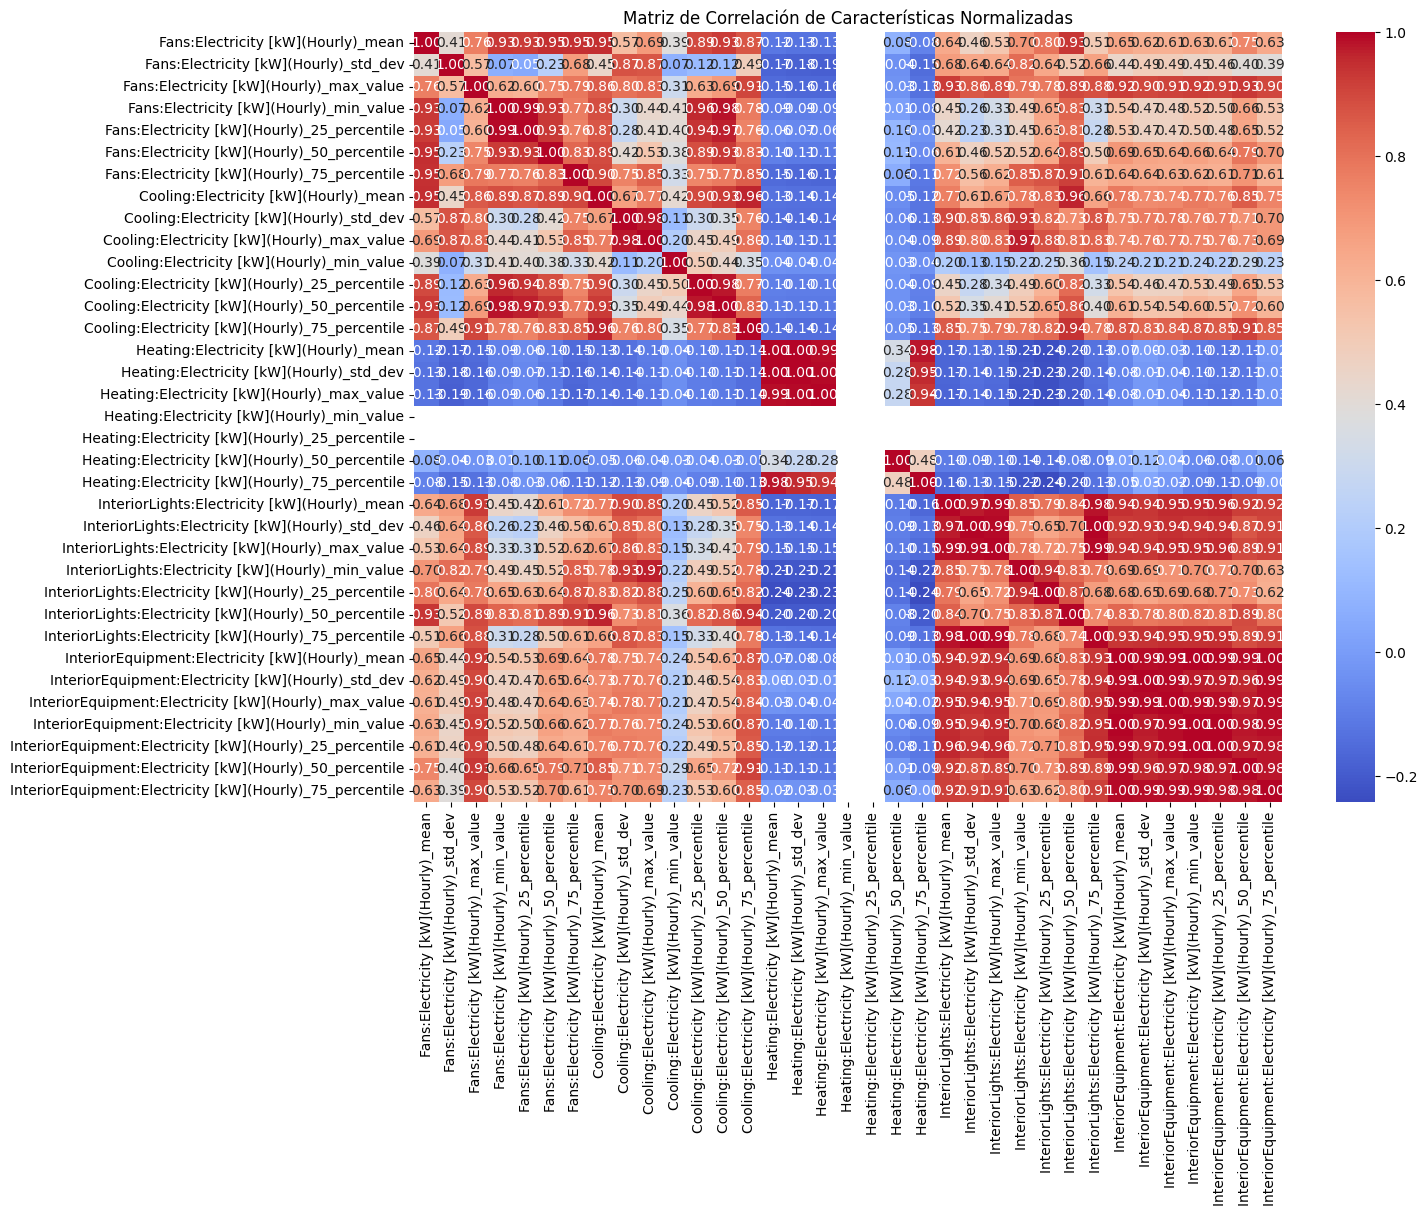

In [83]:
# Calcular la matriz de correlación
correlation_matrix = data_estadisticas_filtrada.corr()

# Mostrar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación de Características Normalizadas')
plt.show()

In [84]:
# Normalizamos los datos
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_estadisticas_filtrada)

# Convertimos el resultado a un DataFrame para facilitar su manejo
data_normalized_df = pd.DataFrame(data_normalized, columns=data_estadisticas_filtrada.columns)

# Mostrar los primeros registros de los datos normalizados
data_normalized_df.head()


,Fans:Electricity [kW](Hourly)_mean,Fans:Electricity [kW](Hourly)_std_dev,Fans:Electricity [kW](Hourly)_max_value,Fans:Electricity [kW](Hourly)_min_value,Fans:Electricity [kW](Hourly)_25_percentile,Fans:Electricity [kW](Hourly)_50_percentile,Fans:Electricity [kW](Hourly)_75_percentile,Cooling:Electricity [kW](Hourly)_mean,Cooling:Electricity [kW](Hourly)_std_dev,Cooling:Electricity [kW](Hourly)_max_value,...,InteriorLights:Electricity [kW](Hourly)_25_percentile,InteriorLights:Electricity [kW](Hourly)_50_percentile,InteriorLights:Electricity [kW](Hourly)_75_percentile,InteriorEquipment:Electricity [kW](Hourly)_mean,InteriorEquipment:Electricity [kW](Hourly)_std_dev,InteriorEquipment:Electricity [kW](Hourly)_max_value,InteriorEquipment:Electricity [kW](Hourly)_min_value,InteriorEquipment:Electricity [kW](Hourly)_25_percentile,InteriorEquipment:Electricity [kW](Hourly)_50_percentile,InteriorEquipment:Electricity [kW](Hourly)_75_percentile
0,-0.561068,-0.610603,-0.606728,-0.373265,-0.259639,-0.553602,-0.669609,-0.486723,-0.555238,-0.637592,...,-0.350157,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065
1,-0.561227,-0.610796,-0.606796,-0.373265,-0.259833,-0.553802,-0.669781,-0.483423,-0.550138,-0.631402,...,-0.350157,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065
2,-0.561262,-0.610838,-0.606811,-0.373265,-0.259875,-0.553845,-0.669818,-0.478767,-0.542565,-0.632981,...,-0.350157,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065
3,-0.562206,-0.611981,-0.607214,-0.373265,-0.261025,-0.555026,-0.670838,-0.495729,-0.576445,-0.637847,...,-0.350157,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065
4,-0.561418,-0.611027,-0.606877,-0.373265,-0.260065,-0.554040,-0.669987,-0.495214,-0.574949,-0.643543,...,-0.350157,-0.50177,-0.648014,-0.468038,-0.560958,-0.556413,-0.462229,-0.351055,-0.415152,-0.464065


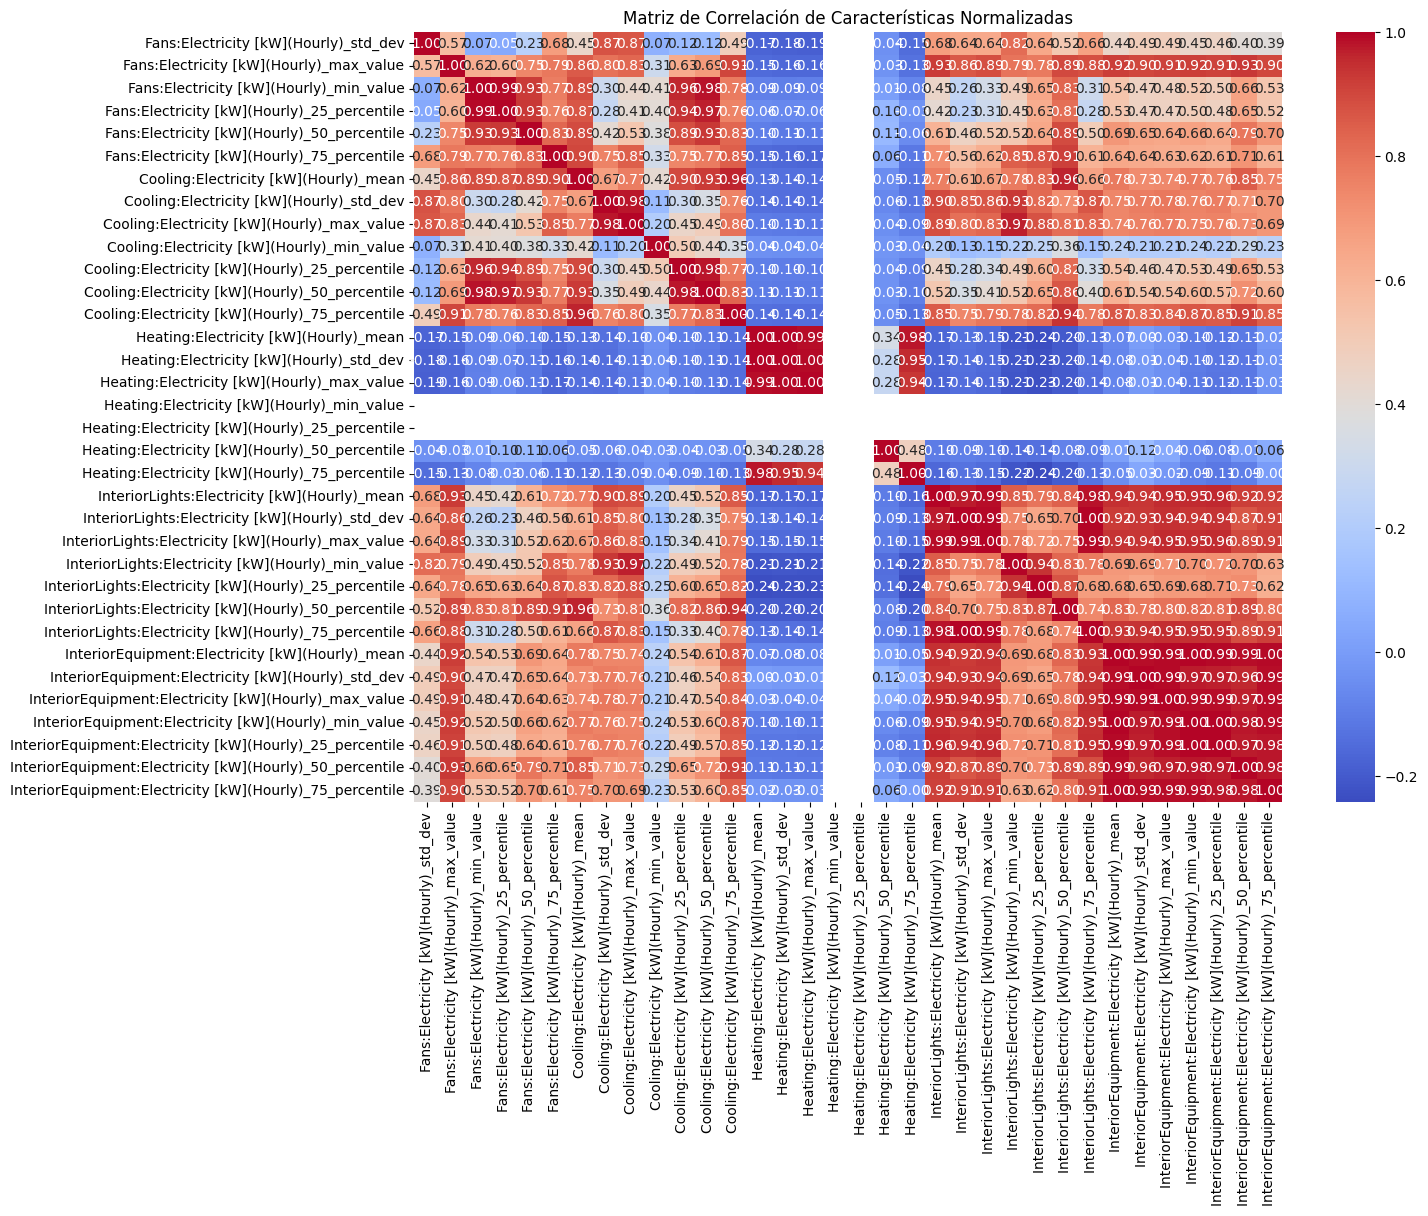

In [85]:
# Calcular la matriz de correlación
correlation_matrix = data_normalized_df.iloc[:,1:].corr()

# Mostrar la matriz de correlación utilizando un mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de Correlación de Características Normalizadas')
plt.show()

## PCA

[2.06961172e+01 4.27486877e+00 4.15196302e+00 1.82590392e+00
 9.88877852e-01 7.98086224e-01 2.45685282e-01 1.44054134e-01
 7.65336370e-02 6.81032589e-02 4.31436353e-02 3.65037725e-02
 2.42339623e-02 1.65608792e-02 1.17574207e-02 4.67969003e-03
 3.19076190e-03 2.78807921e-03 2.32848545e-03 1.22885234e-03
 5.67059100e-04 1.98296847e-04 1.19917645e-04 7.68522055e-05
 5.70009573e-05 4.70674365e-05 2.77623233e-05 1.38207416e-05
 3.48747973e-06 1.29596352e-06 1.15336372e-07 1.94409926e-08
 2.51013985e-09 1.47946378e-31 1.47946378e-31]


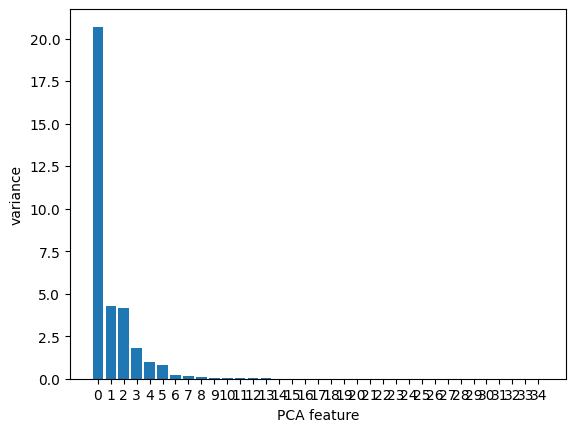

In [86]:
# Create a PCA instance: pca
pca = PCA()
# Fit the pipeline to 'samples'
pca.fit(data_normalized_df)
print(pca.explained_variance_)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

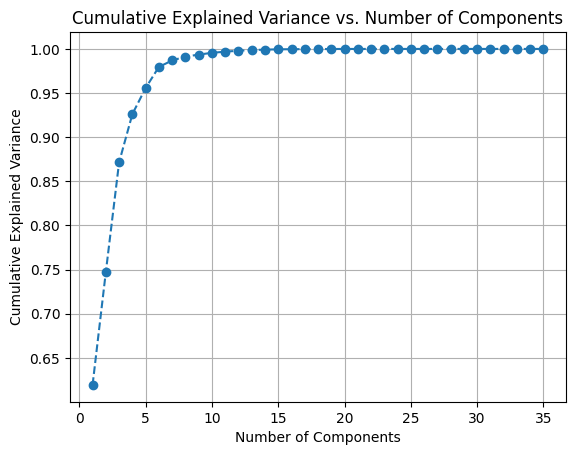

In [87]:
# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [88]:
# Reducir la dimensionalidad utilizando PCA para seleccionar características no correlacionadas
pca = PCA(n_components=5)  # Seleccionamos un número razonable de componentes principales
data_pca = pca.fit_transform(data_normalized_df)

# Convertimos los componentes principales a un DataFrame para facilitar su manejo
data_pca_df = pd.DataFrame(data_pca, columns=[f'PC{i+1}' for i in range(data_pca.shape[1])])

# Mostrar los primeros registros de los datos transformados
data_pca_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-2.623952,-0.124882,-0.951664,-0.513599,-0.072411
1,-2.619438,-0.125494,-0.951409,-0.510245,-0.073012
2,-2.615158,-0.125315,-0.951509,-0.508465,-0.073600
3,-2.633551,-0.124024,-0.951757,-0.520941,-0.072284
4,-2.633056,-0.122902,-0.952267,-0.521612,-0.071878


## CLUSTERING 

### KMEANS

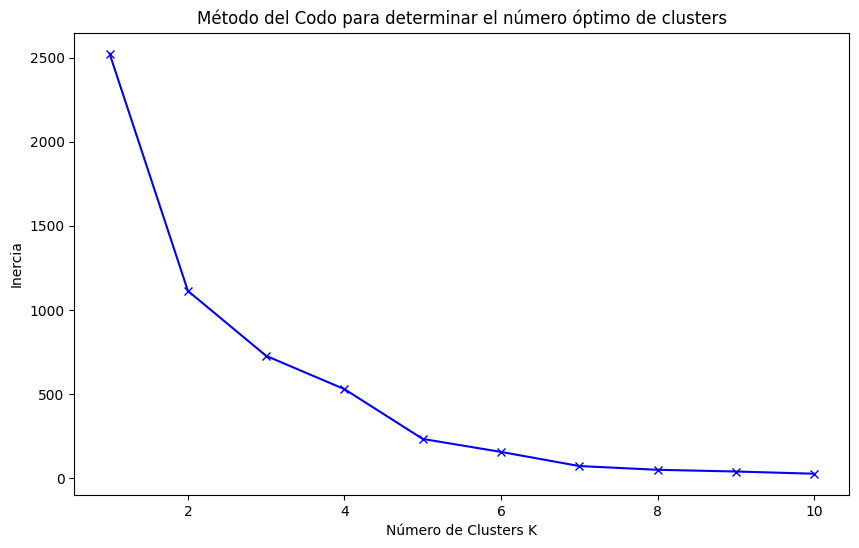

In [89]:
# Método del Codo para K-means
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca_df.iloc[:, :5])
    inertia.append(kmeans.inertia_)

# Gráfico del Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Número de Clusters K')
plt.ylabel('Inercia')
plt.title('Método del Codo para determinar el número óptimo de clusters')
plt.show()

In [91]:
# Calcular las diferencias entre inercias
inertia_differences = [j - i for i, j in zip(inertia[:-1], inertia[1:])]
# Imprimir las diferencias entre inercias
for i, diff in enumerate(inertia_differences, start=2):
    print(f"Diferencia de inercia entre {i-1} y {i} clusters: {diff}")

Diferencia de inercia entre 1 y 2 clusters: -1410.1478621575507
Diferencia de inercia entre 2 y 3 clusters: -386.3821144661341
Diferencia de inercia entre 3 y 4 clusters: -197.7830829055971
Diferencia de inercia entre 4 y 5 clusters: -295.9666695837014
Diferencia de inercia entre 5 y 6 clusters: -77.0950234605109
Diferencia de inercia entre 6 y 7 clusters: -84.0084692578804
Diferencia de inercia entre 7 y 8 clusters: -22.293604636206148
Diferencia de inercia entre 8 y 9 clusters: -10.137842988157843
Diferencia de inercia entre 9 y 10 clusters: -13.18629778178407


basandonos en la grafica de los cambios de inercia  utilizamos el metodo del codo para determinar el numero optimo de clusters a agrupar estan entre 2 a 3

In [92]:
# Aplicar K-means con un número de clusters razonable, por ejemplo, 3
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_kmeans = kmeans.fit_predict(data_pca_df.iloc[:, :5])

# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_kmeans = silhouette_score(data_pca_df.iloc[:, :5], clusters_kmeans)

# Agregar los clusters al DataFrame para análisis posterior
data_pca_df['Cluster_KMeans'] = clusters_kmeans

# Mostrar los primeros registros con los clusters asignados
data_pca_df.head(), silhouette_kmeans

(        PC1       PC2       PC3       PC4       PC5  Cluster_KMeans
 0 -2.623952 -0.124882 -0.951664 -0.513599 -0.072411               0
 1 -2.619438 -0.125494 -0.951409 -0.510245 -0.073012               0
 2 -2.615158 -0.125315 -0.951509 -0.508465 -0.073600               0
 3 -2.633551 -0.124024 -0.951757 -0.520941 -0.072284               0
 4 -2.633056 -0.122902 -0.952267 -0.521612 -0.071878               0,
 0.7067738362928584)

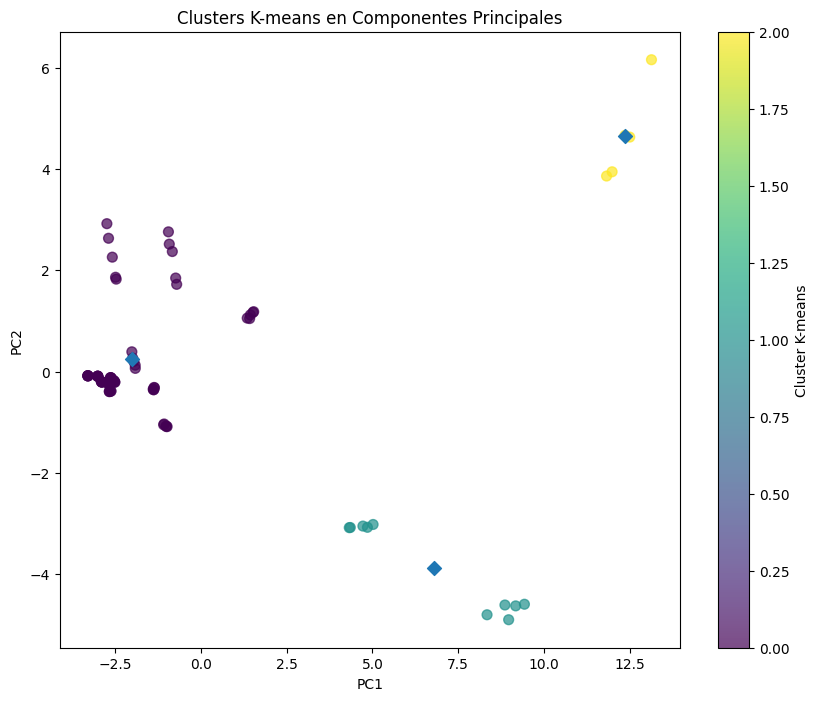

In [95]:
# Visualización de los clusters obtenidos por K-means
plt.figure(figsize=(10, 8))
plt.scatter(data_pca_df["PC1"], data_pca_df['PC2'], c=data_pca_df['Cluster_KMeans'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters K-means en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster K-means')
# Assign the cluster centers: centroids
centroids = kmeans.cluster_centers_

# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
"""
scatter plot of centroids_x and centroids_y, using 'D' (a diamond) as a marker by specifying the marker parameter. Set the size of the markers to be 50 using s=50.
"""
plt.scatter(centroids_x,centroids_y,marker="D",s=50)
plt.show()

## DBSCAN

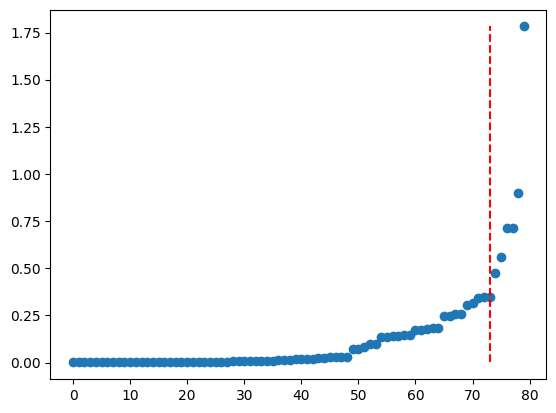

0.34895412510713497


In [96]:
#Calling our main function
idx, eps = get_eps(data_pca_df.iloc[:, :3])

#Showing the rotated version used for find the elbow.
plt.show()

#Printing the exact values of our eps, from here we will round it
#and use it for our DBSCAN method.
print(eps)

In [103]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(data_pca_df.iloc[:, :5])

# Calcular el silhouette score para evaluar la calidad de los clusters, excluyendo los puntos ruidosos
if len(set(clusters_dbscan)) > 1:
    silhouette_dbscan = silhouette_score(data_pca_df.iloc[:, :5], clusters_dbscan)
else:
    silhouette_dbscan = -1  # Silhouette score no es aplicable si hay un solo cluster

# Agregar los clusters al DataFrame para análisis posterior
data_pca_df['Cluster_DBSCAN'] = clusters_dbscan

# Mostrar los primeros registros con los clusters asignados por DBSCAN
data_pca_df.head(), silhouette_dbscan

(        PC1       PC2       PC3       PC4       PC5  Cluster_KMeans  \
 0 -2.623952 -0.124882 -0.951664 -0.513599 -0.072411               0   
 1 -2.619438 -0.125494 -0.951409 -0.510245 -0.073012               0   
 2 -2.615158 -0.125315 -0.951509 -0.508465 -0.073600               0   
 3 -2.633551 -0.124024 -0.951757 -0.520941 -0.072284               0   
 4 -2.633056 -0.122902 -0.952267 -0.521612 -0.071878               0   
 
    Cluster_DBSCAN  
 0               0  
 1               0  
 2               0  
 3               0  
 4               0  ,
 0.5077019167893141)

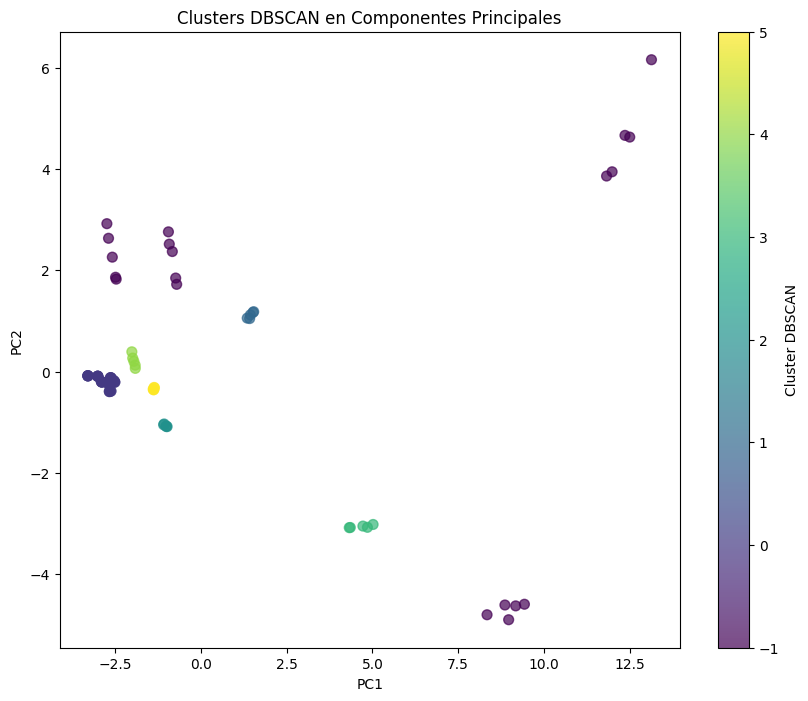

In [104]:
# Visualización de los clusters obtenidos por DBSCAN
plt.figure(figsize=(10, 8))
plt.scatter(data_pca_df['PC1'], data_pca_df['PC2'], c=data_pca_df['Cluster_DBSCAN'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters DBSCAN en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster DBSCAN')
plt.show()

## CLUSTERING HERARQUICO 

In [105]:
data_pca_df

,PC1,PC2,PC3,PC4,PC5,Cluster_KMeans,Cluster_DBSCAN
0,-2.623952,-0.124882,-0.951664,-0.513599,-0.072411,0,0
1,-2.619438,-0.125494,-0.951409,-0.510245,-0.073012,0,0
2,-2.615158,-0.125315,-0.951509,-0.508465,-0.073600,0,0
3,-2.633551,-0.124024,-0.951757,-0.520941,-0.072284,0,0
4,-2.633056,-0.122902,-0.952267,-0.521612,-0.071878,0,0
...,...,...,...,...,...,...,...
75,-2.664223,-0.389585,-0.951011,-0.087708,-0.098356,0,0
76,-2.662452,-0.395771,-0.949011,-0.079894,-0.099709,0,0
77,-2.663213,-0.396815,-0.948778,-0.079808,-0.100192,0,0
78,-2.617031,-0.384815,-0.961568,-0.016781,-0.070851,0,0


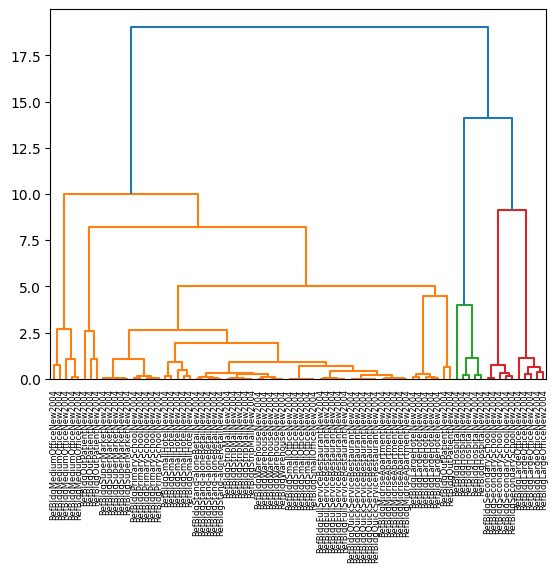

In [106]:
# Calculate the linkage: mergings
mergings = linkage(data_pca_df.iloc[:, :5],method='complete')

# Plot the dendrogram
dendrogram(mergings,labels=nombres_edificios.tolist(),leaf_rotation=90,leaf_font_size=6)
plt.show()

In [107]:
# Calcular el linkage matrix
mergings = linkage(data_pca_df.iloc[:, :5], method='single')

# Calcular las alturas de los clusters
last = mergings[-10:, 2]
last_rev = last[::-1]
indexes = np.arange(1, len(last) + 1)

# Calcular la aceleración
acceleration = np.diff(last, 2)  # Segunda derivada de las alturas
acceleration_rev = acceleration[::-1]

# Encontrar el número óptimo de clusters
k = acceleration_rev.argmax() + 2  # +2 porque la primera derivada se pierde y Python indexa desde 0

print(f'El número óptimo de clusters es: {k}')

El número óptimo de clusters es: 4


In [112]:
# Aplicar Clustering Jerárquico
hierarchical = AgglomerativeClustering(n_clusters=3)
clusters_hierarchical = hierarchical.fit_predict(data_pca_df.iloc[:, :5])

# Calcular el silhouette score para evaluar la calidad de los clusters
silhouette_hierarchical = silhouette_score(data_pca_df.iloc[:, :5], clusters_hierarchical)

# Agregar los clusters al DataFrame para análisis posterior
data_pca_df['Cluster_Hierarchical'] = clusters_hierarchical

# Mostrar los primeros registros con los clusters asignados por Clustering Jerárquico
data_pca_df.head(), silhouette_hierarchical

(        PC1       PC2       PC3       PC4       PC5  Cluster_KMeans  \
 0 -2.623952 -0.124882 -0.951664 -0.513599 -0.072411               0   
 1 -2.619438 -0.125494 -0.951409 -0.510245 -0.073012               0   
 2 -2.615158 -0.125315 -0.951509 -0.508465 -0.073600               0   
 3 -2.633551 -0.124024 -0.951757 -0.520941 -0.072284               0   
 4 -2.633056 -0.122902 -0.952267 -0.521612 -0.071878               0   
 
    Cluster_DBSCAN  Cluster_Hierarchical  
 0               0                     0  
 1               0                     0  
 2               0                     0  
 3               0                     0  
 4               0                     0  ,
 0.7067738362928584)

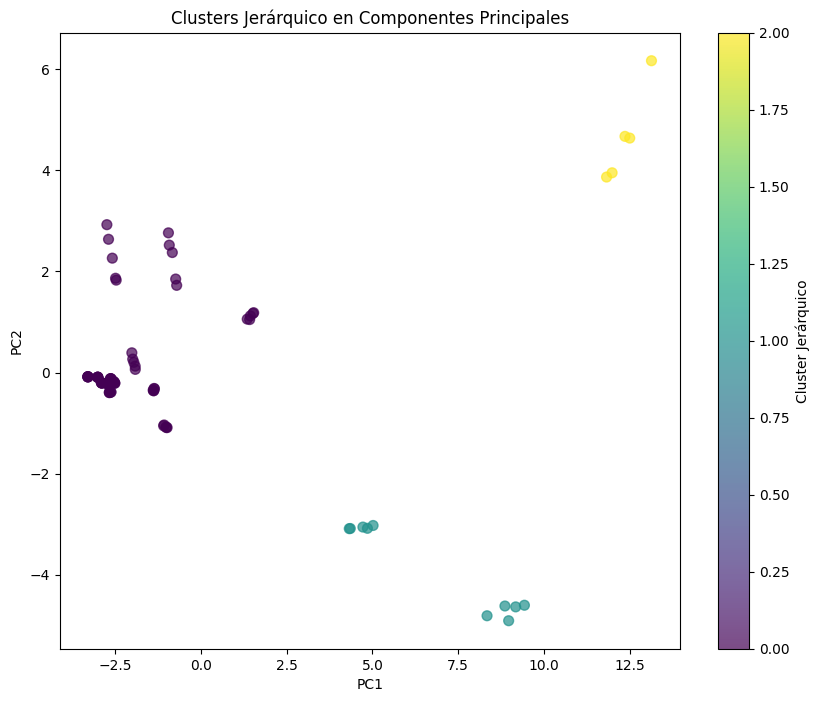

In [113]:
# Visualización de los clusters obtenidos por Clustering Jerárquico
plt.figure(figsize=(10, 8))
plt.scatter(data_pca_df["PC1"], data_pca_df['PC2'], c=data_pca_df['Cluster_Hierarchical'], cmap='viridis', s=50, alpha=0.7)
plt.title('Clusters Jerárquico en Componentes Principales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster Jerárquico')
plt.show()

In [114]:
data_pca_df.shape

(80, 8)